In [8]:
import os
import pandas as pd
import librosa
import librosa.display
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import soundfile
import pickle

from audiomentations import Compose, TimeStretch, PitchShift, Shift, Trim, Gain, PolarityInversion
from sklearn.model_selection import train_test_split

Augment the positive samples

In [33]:
augment = Compose([
    TimeStretch(min_rate=0.7, max_rate=1.4, p=0.9),
    PitchShift(min_semitones=-2, max_semitones=4, p=1),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.8),
    Trim(p=1),
    Gain(p=1),
    PolarityInversion(p=0.8)
    
])

In [2]:
### Setup paths and directories
dataset_path = ".."
rawdata_path = os.path.join(dataset_path, "Extracted_data")
out_path = "raw"
metadata_path = os.path.join(dataset_path, "combined_data.csv")

In [3]:
metadata = pd.read_csv(metadata_path, sep = ",")

In [4]:
metadata["covid"] = 'X'
metadata.loc[metadata["covid_status"] == "healthy", "covid"] = 0
metadata.loc[(metadata["covid_status"] == "positive_mild") | (metadata["covid_status"] == "positive_moderate"), "covid"] = 1
metadata = metadata.loc[metadata["covid"] != 'X']

In [5]:
print(metadata[['covid','id']].groupby(['covid']).count().rename(columns={'id':'N_entries'}))

       N_entries
covid           
0           1433
1            591


In [24]:
positive = metadata.loc[metadata["covid"] == 1]
negative = metadata.loc[metadata["covid"] == 0].sample(n = 982)

In [43]:
(len(positive) - 200) * 2 + 200

982

In [25]:
positive_train, positive_test = train_test_split(positive, test_size = 200, random_state = 7)
negative_train, negative_test = train_test_split(negative, test_size = 200, random_state = 7)

In [28]:
train = pd.concat([positive_train, negative_train])
train = train.sample(frac = 1)
test = pd.concat([positive_test, negative_test])
test = test.sample(frac = 1)

In [35]:
train_data = {
    "filename": [],
    "signal": [],
    "label": []
}

sample_rate = 48000
fix_length = sample_rate * 3

for uuid, covid in tqdm(zip(train["id"].values, train["covid"].values), total = len(train)):

    file_path = os.path.join(rawdata_path, uuid, "cough-heavy.wav")
    
    if not os.path.exists(file_path):
        print(f"could not find audio file for uuid: {uuid}")
        continue

    signal, sr = librosa.load(file_path, sr = None)

    if signal.size == 0:
        print("Empty audio")
        continue

    if sr != sample_rate:
        print("Resampling...")
        signal = librosa.resample(signal, orig_sr = sr, target_sr = sample_rate)

    if covid == 1:
        for i in range(1):
            augmented = augment(signal, sample_rate)
            augmented = librosa.util.fix_length(augmented, size = fix_length)
            train_data["filename"].append(uuid + f"_augmented_{i}")
            train_data["signal"].append(augmented)
            train_data["label"].append(covid)
        
    signal = librosa.util.fix_length(signal, size = fix_length)

    train_data["filename"].append(uuid)
    train_data["signal"].append(signal)
    train_data["label"].append(covid)


  0%|          | 0/1173 [00:00<?, ?it/s]

Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Empty audio
Resampling...
Empty audio
Empty audio
Empty audio
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Empty audio
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Empty audio
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Empty audio
Empty audio
Resampling...
Resampling...
Resampling...
Empty audio
Empty audio
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling..

In [44]:
for i, filename in enumerate(train_data["filename"]):
    if filename[-2:] == "_1":
        train_data["filename"].pop(i)
        train_data["signal"].pop(i)
        train_data["label"].pop(i)

In [70]:
sum(train_data["label"]) / len(train_data["label"])

0.5042016806722689

In [61]:
test_data = {
    "filename": [],
    "signal": [],
    "label": []
}

sample_rate = 48000
fix_length = sample_rate * 3

for uuid, covid in tqdm(zip(test["id"].values, test["covid"].values), total = len(test)):

    file_path = os.path.join(rawdata_path, uuid, "cough-heavy.wav")
    
    if not os.path.exists(file_path):
        print(f"could not find audio file for uuid: {uuid}")
        continue

    signal, sr = librosa.load(file_path, sr = None)

    if signal.size == 0:
        print("Empty audio")
        continue

    if sr != sample_rate:
        print("Resampling...")
        signal = librosa.resample(signal, orig_sr = sr, target_sr = sample_rate)
        
    signal = librosa.util.fix_length(signal, size = fix_length)

    test_data["filename"].append(uuid)
    test_data["signal"].append(signal)
    test_data["label"].append(covid)


  0%|          | 0/400 [00:00<?, ?it/s]

Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Empty audio
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Empty audio
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Empty audio
Empty audio
Resampling...
Resampling...


In [88]:
len(train_data["label"]) + len(test_data["label"])

1943

In [71]:
with open("train_signals_144000.pkl", "wb") as f:
    pickle.dump(train_data, f)

with open("test_signals_144000.pkl", "wb") as f:
    pickle.dump(test_data, f)

In [52]:
import numpy as np
import os
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import sys
sys.path.append(r'../../..')
from models import CovidCNNModel, CovidDataset, train, testModel, plotTrainingProcess, testPerformance

%load_ext autoreload
%autoreload 1
%aimport models


In [53]:
# Set dataset path
datasetPath = r"."
# rawDataPath = os.path.join(datasetPath, "raw")

In [54]:
# Use GPU to train and infer
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [72]:
n_mfcc = 39
frame_length = 2048 # about 40ms per frame
hop_length = frame_length // 2

X_train = librosa.feature.mfcc(y = np.asarray(train_data["signal"]), n_mfcc = n_mfcc, n_fft = frame_length, hop_length = hop_length)
y_train = np.asarray(train_data["label"])
X_test = librosa.feature.mfcc(y = np.asarray(test_data["signal"]), n_mfcc = n_mfcc, n_fft = frame_length, hop_length = hop_length)
y_test = np.asarray(test_data["label"])

In [78]:
X_train = X_train[:, None, :, :]
print(X_train.shape)

(1547, 1, 39, 141)


In [79]:
X_test = X_test[:, None, :, :]

(1547, 1, 39, 141)


In [80]:
print(X_test.shape)

(396, 1, 39, 141)


In [81]:
batch_size = 100
n_class = 2

trainset = CovidDataset(X_train, y_train, n_class)
trainloader = DataLoader(trainset, batch_size, shuffle = True, num_workers = 0)

valset = CovidDataset(X_test, y_test, n_class)
valloader = DataLoader(valset, batch_size, shuffle = True, num_workers = 0)

In [83]:
model = CovidCNNModel(trainset)
model.to(device)

CovidCNNModel(
  (backbone): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 32, kernel_size=(2, 2), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (linear): Sequential(
    (0): Linear(in_features=36992, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [84]:
record_freq = 5
epoch_num = 10
train_accuracies, train_losses, val_accuracies, val_losses, out_dir = train(
    model = model, 
    trainloader = trainloader, 
    valloader = valloader, 
    epoch_num = epoch_num,
    record_freq = record_freq,
    out_dir = datasetPath)

[2022-10-07 14:52:22] [epoch:1, batch:  1] training loss: 0.7162, training accuracy: 0.430, validation loss: 0.7024, validation accuracy: 0.538, time used:  0.5 s, total time used:  0.5 s.
[2022-10-07 14:52:23] [epoch:1, batch:  2] training loss: 0.6690, training accuracy: 0.600, validation loss: 0.7387, validation accuracy: 0.533, time used:  0.8 s, total time used:  0.8 s.
[2022-10-07 14:52:25] [epoch:1, batch:  3] training loss: 0.6876, training accuracy: 0.600, validation loss: 0.7409, validation accuracy: 0.545, time used:  3.0 s, total time used:  3.0 s.
[2022-10-07 14:52:27] [epoch:1, batch:  4] training loss: 0.6432, training accuracy: 0.600, validation loss: 0.7523, validation accuracy: 0.551, time used:  5.1 s, total time used:  5.1 s.
[2022-10-07 14:52:29] [epoch:1, batch:  5] training loss: 0.5795, training accuracy: 0.750, validation loss: 0.7803, validation accuracy: 0.553, time used:  7.0 s, total time used:  7.0 s.
[2022-10-07 14:52:31] [epoch:1, batch:  6] training los

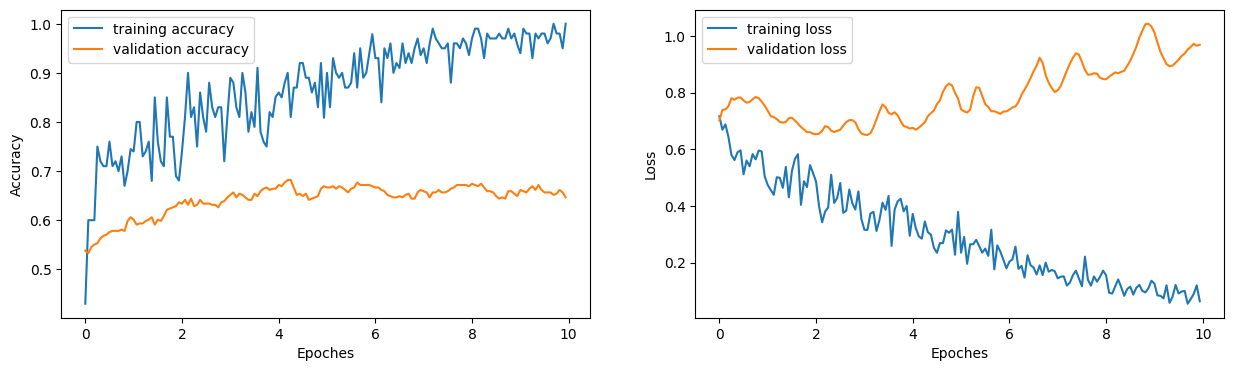

In [85]:
plotTrainingProcess(
    record_freq, 
    trainloader, 
    train_accuracies, 
    train_losses, 
    val_accuracies, 
    val_losses,
    out_dir
    )

[2022-10-07 14:54:17] [test performance] Test accuracy: 0.646, Test loss: 0.9686
[2022-10-07 14:54:17] [class: 0] AUC: 0.7309772211310359
[2022-10-07 14:54:20] [class: 1] AUC: 0.730977221131036


(0.6464646464646465, 0.9685638504798966, array([0.73097722, 0.73097722]))

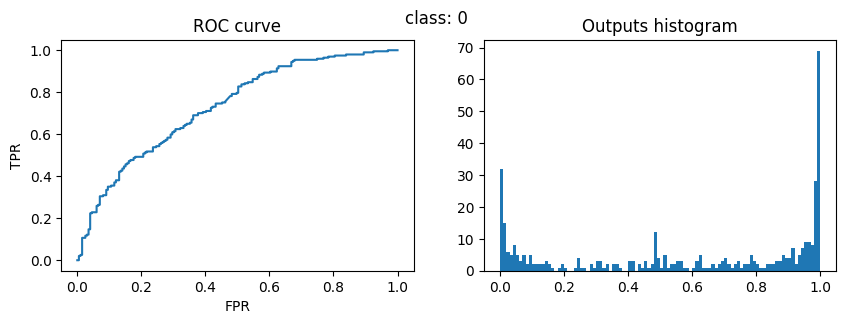

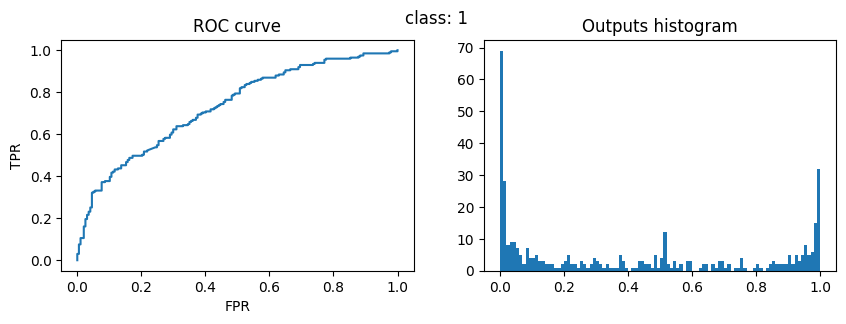

In [86]:
testPerformance(model, valloader, out_dir = out_dir)